<a href="https://colab.research.google.com/github/irymna/NLP-PrimeiroProjeto/blob/main/Projeto_NLP_Amazon_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Trainee - NLP

Farei uma análise de sentimentos com um dataset de reviews de jogos da Amazon para a admissão na área de Processamento de Linguagem Natural (NLP) dentro do Turing USP, grupo de extensão da Universidade de São Paulo.

##Observações iniciais

In [59]:
# Importando as bibliotecas essenciais
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from collections import Counter

# Bibliotecas para manipular os textos
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer # Stemização
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualização dos dados
import seaborn as sns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
amazon_train = pd.read_csv('video_games_reviews_train.csv')
amazon_test = pd.read_csv('video_games_reviews_test.csv')
amazon_dev = pd.read_csv('video_games_reviews_dev.csv')

In [3]:
amazon_train.head()

,level_0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,9604,222941,A1U1AK7HKB2BLN,B00CX6XKK6,jayfer,"[4, 51]",ive got to play this on both consoles now and ...,1,wasted 500 dollars on the xbox one.,1385078400,"11 22, 2013"
1,5428,106670,A1L1D50VH2AX7J,B0017UFWMS,Anjoyla,"[0, 0]",This game gives you a series of word puzzles t...,2,Margots Word Brain,1321833600,"11 21, 2011"
2,198,24455,A2JWU211CM0BYE,B00005RCR0,DCN2049,"[0, 1]",You should pretty much already know what this ...,4,"Excellent product, watch the discs",1360540800,"02 11, 2013"
3,6070,42574,A1DP3YZ2OQWAP4,B0000ARQMW,liz,"[0, 0]",I really like this game i love all the challen...,5,Jammin banging game,1383436800,"11 3, 2013"
4,11616,172598,A48Z207T98FN0,B004HYK8Y8,The Reverend,"[296, 368]",*** please read the 12/9/11 update below this ...,1,Consumers are NOT Beta-Testers !!! (updated),1322784000,"12 2, 2011"


**Descrição das colunas:**

reviewerID - ID da pessoa do review

asin - ID do produto

reviewerName - nome do reviewer

helpful - classificação da review

reviewText - texto review → *importante*

overall - nota do produto → *importante*

summary - sumário da review

unixReviewTime - data da review (unix time)

reviewTime - data da review

In [4]:
amazon_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   level_0         8000 non-null   int64 
 1   index           8000 non-null   int64 
 2   reviewerID      8000 non-null   object
 3   asin            8000 non-null   object
 4   reviewerName    7916 non-null   object
 5   helpful         8000 non-null   object
 6   reviewText      7999 non-null   object
 7   overall         8000 non-null   int64 
 8   summary         8000 non-null   object
 9   unixReviewTime  8000 non-null   int64 
 10  reviewTime      8000 non-null   object
dtypes: int64(4), object(7)
memory usage: 687.6+ KB


In [5]:
amazon_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   level_0         2500 non-null   int64 
 1   index           2500 non-null   int64 
 2   reviewerID      2500 non-null   object
 3   asin            2500 non-null   object
 4   reviewerName    2471 non-null   object
 5   helpful         2500 non-null   object
 6   reviewText      2499 non-null   object
 7   overall         2500 non-null   int64 
 8   summary         2500 non-null   object
 9   unixReviewTime  2500 non-null   int64 
 10  reviewTime      2500 non-null   object
dtypes: int64(4), object(7)
memory usage: 215.0+ KB


In [6]:
amazon_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   level_0         2000 non-null   int64 
 1   index           2000 non-null   int64 
 2   reviewerID      2000 non-null   object
 3   asin            2000 non-null   object
 4   reviewerName    1970 non-null   object
 5   helpful         2000 non-null   object
 6   reviewText      2000 non-null   object
 7   overall         2000 non-null   int64 
 8   summary         2000 non-null   object
 9   unixReviewTime  2000 non-null   int64 
 10  reviewTime      2000 non-null   object
dtypes: int64(4), object(7)
memory usage: 172.0+ KB


##Limpeza dos dados

Limparei apenas os dados faltantes na coluna dos reviews pois é a parte em que trabalharemos nesse projeto. 

In [7]:
amazon_train = amazon_train[~amazon_train['reviewText'].isnull()]

In [8]:
amazon_test = amazon_test[~amazon_test['reviewText'].isnull()]

##Pré-processamento

Etapa necessária para simplificar e reduzir o texto para o processamento eficaz dos modelos.

In [9]:
!spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [10]:
import spacy
nlp = spacy.load("en_core_web_sm") # lematizador da biblioteca spacy

In [11]:
stopwords = nltk.corpus.stopwords.words('english')

In [12]:
def limpa_texto(texto):
  '''
  Essa funcao recebe uma string, deixa tudo em minusculo, filtra apenas letras,
  retira stopwords, lemmatiza e retorna a string resultante.
  
  '''
  texto = texto.lower()

  texto = re.sub(r"[\W\d_]+", " ", texto)

  texto = [pal for pal in texto.split() if pal not in stopwords]

  spc_texto = nlp(" ".join(texto))
  tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in spc_texto]
  
  return " ".join(tokens)

Aplicando a função em um novo dataframe:

In [13]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_dev = pd.DataFrame()

In [14]:
df_train['Nota'] = amazon_train['overall']
df_train['Review'] = amazon_train['reviewText'].apply(limpa_texto)

In [15]:
df_test['Nota'] = amazon_test['overall']
df_test['Review'] = amazon_test['reviewText'].apply(limpa_texto)

In [16]:
df_dev['Nota'] = amazon_dev['overall']
df_dev['Review'] = amazon_dev['reviewText'].apply(limpa_texto)

###Tokenização

Para uma melhor análise do texto, é interessante separar as palavras de forma única, formando tokens. Aqui, farei isso somento no `df_train`.

In [19]:
df_train['Tokenização'] = df_train['Review'].apply(word_tokenize) 

In [20]:
df_train

,Nota,Review,Tokenização
0,1,i have get play console honestly say look x be...,"[i, have, get, play, console, honestly, say, l..."
1,2,game give series word puzzle figure buy fan sc...,"[game, give, series, word, puzzle, figure, buy..."
2,4,pretty much already know game reading review b...,"[pretty, much, already, know, game, reading, r..."
3,5,really like game love challenge love different...,"[really, like, game, love, challenge, love, di..."
4,1,please read update article ps user bad news ma...,"[please, read, update, article, ps, user, bad,..."
...,...,...,...
7995,3,arrive mail promptly work great far download d...,"[arrive, mail, promptly, work, great, far, dow..."
7996,2,game perfect example style substance good grap...,"[game, perfect, example, style, substance, goo..."
7997,5,let tell start big yu gi oh fan collect card m...,"[let, tell, start, big, yu, gi, oh, fan, colle..."
7998,5,new game deliver buy game solely web swing aro...,"[new, game, deliver, buy, game, solely, web, s..."


###Notas

Aqui é interessante atribuir um valor binário as notas dadas, que vão até 5. Com isso, as notas 1, 2 e 3 receberão o valor 0 (negativo) e as de valor 4 e 5 o valor 1 (positivo).

In [21]:
df_train['Nota'] = np.where(df_train.Nota>3,1,0)
df_test['Nota'] = np.where(df_test.Nota>3,1,0)
df_dev['Nota'] = np.where(df_dev.Nota>3,1,0)

In [22]:
df_train

,Nota,Review,Tokenização
0,0,i have get play console honestly say look x be...,"[i, have, get, play, console, honestly, say, l..."
1,0,game give series word puzzle figure buy fan sc...,"[game, give, series, word, puzzle, figure, buy..."
2,1,pretty much already know game reading review b...,"[pretty, much, already, know, game, reading, r..."
3,1,really like game love challenge love different...,"[really, like, game, love, challenge, love, di..."
4,0,please read update article ps user bad news ma...,"[please, read, update, article, ps, user, bad,..."
...,...,...,...
7995,0,arrive mail promptly work great far download d...,"[arrive, mail, promptly, work, great, far, dow..."
7996,0,game perfect example style substance good grap...,"[game, perfect, example, style, substance, goo..."
7997,1,let tell start big yu gi oh fan collect card m...,"[let, tell, start, big, yu, gi, oh, fan, colle..."
7998,1,new game deliver buy game solely web swing aro...,"[new, game, deliver, buy, game, solely, web, s..."


##Análise do corpus

Olharei somente as reviews do dataframe `df_train`.

###Frequência de termos

In [23]:
# Juntarei todas as palavras numa lista só para poder fazer a manipulação.
list_of_lists = df_train["Tokenização"]
list_geral = []
for l in list_of_lists:
    for element in l:
        list_geral.append(element)

len(list_geral) # quantidade de palavras

886360

In [24]:
# Ranking de palavras mais comuns 
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
nltk.download('punkt')

fd = FreqDist(list_geral)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


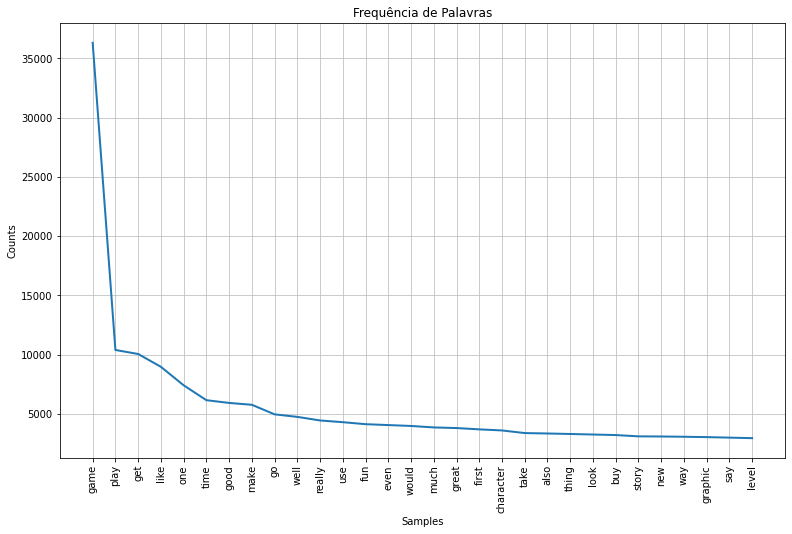

In [25]:
plt.figure(figsize = (13, 8))
fd.plot(30, title = "Frequência de Palavras")

A palavra "game" aparece com muita frequência, o que é compreensível pois são reviews de jogos. Talvez o mais indicado seria adicionar essa palavra como uma stopword, mas não farei isso nesse projeto.

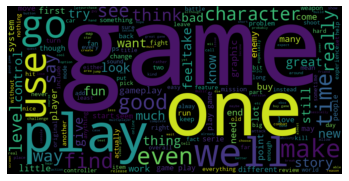

In [33]:
# Wordcloud com as palavras mais citadas
from wordcloud import WordCloud

text = " ".join(i for i in list_geral)
wordcloud = WordCloud(background_color='black', width=1000, height=500).generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

####N-gramas

Vendo a frequência das palavras agora em conjunto, tanto em bigramas quanto em trigramas.

In [26]:
from nltk.util import ngrams

In [27]:
# bigramas
from nltk import bigrams

bigrams = list(bigrams(list_geral))
bigrams[:10]

[('i', 'have'),
 ('have', 'get'),
 ('get', 'play'),
 ('play', 'console'),
 ('console', 'honestly'),
 ('honestly', 'say'),
 ('say', 'look'),
 ('look', 'x'),
 ('x', 'better'),
 ('better', 'ps')]

In [28]:
import collections

# bigramas mais frequentes
bigram_counts = collections.Counter(bigrams)
bifreq = bigram_counts.most_common(10)
bigram_df = pd.DataFrame(bifreq, columns=['Bigrama', 'Frequência'])

bigram_df

,Bigrama,Frequência
0,"(game, play)",1191
1,"(play, game)",1155
2,"(feel, like)",809
3,"(game, like)",641
4,"(can, not)",609
5,"(good, game)",578
6,"(buy, game)",574
7,"(video, game)",541
8,"(great, game)",533
9,"(single, player)",532


In [29]:
# trigramas
from nltk import trigrams

trigrams = list(trigrams(list_geral))
trigrams[:10]

[('i', 'have', 'get'),
 ('have', 'get', 'play'),
 ('get', 'play', 'console'),
 ('play', 'console', 'honestly'),
 ('console', 'honestly', 'say'),
 ('honestly', 'say', 'look'),
 ('say', 'look', 'x'),
 ('look', 'x', 'better'),
 ('x', 'better', 'ps'),
 ('better', 'ps', 'maybe')]

In [30]:
# trigramas mais frequentes
trigram_counts = collections.Counter(trigrams)
trifreq = trigram_counts.most_common(10)
trigram_df = pd.DataFrame(trifreq, columns=['Trigrama', 'Frequência'])

trigram_df

,Trigrama,Frequência
0,"(first, person, shooter)",154
1,"(game, ever, play)",111
2,"(single, player, game)",90
3,"(game, feel, like)",80
4,"(grand, theft, auto)",77
5,"(single, player, campaign)",75
6,"(metal, gear, solid)",64
7,"(single, player, mode)",58
8,"(one, good, game)",57
9,"(play, single, player)",55


###Tamanho das reviews

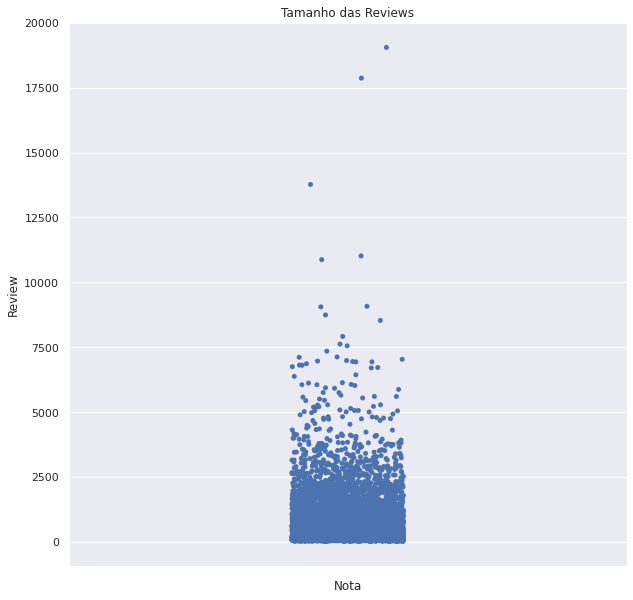

In [46]:
review_size = df_train['Review'].apply(len)

plt.figure(figsize=(10,10))
sns.stripplot(y = review_size)
sns.set_theme(style='darkgrid')
plt.title('Tamanho das Reviews')
plt.xlabel('Nota')
plt.show()

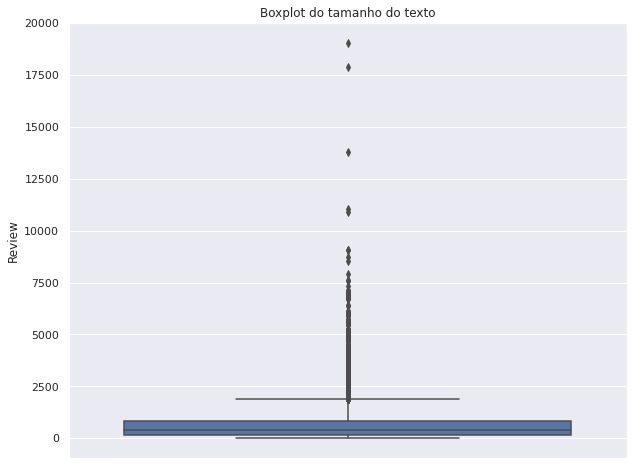

In [48]:
plt.figure(figsize=(10,8))
sns.boxplot(y = review_size)
plt.title("Boxplot do tamanho do texto")
plt.show()

Maioria das reviews tem por volta de 2500 caracteres, mas claro que sempre tem alguém para fazer um textão. 

### Análise das notas

Um bom modo de analisar o sentimento das pessoas é ver as notas que elas atribuem aos produtos.

In [49]:
Review_Nota = pd.DataFrame()
Review_Nota['Nota'] = df_train['Nota']

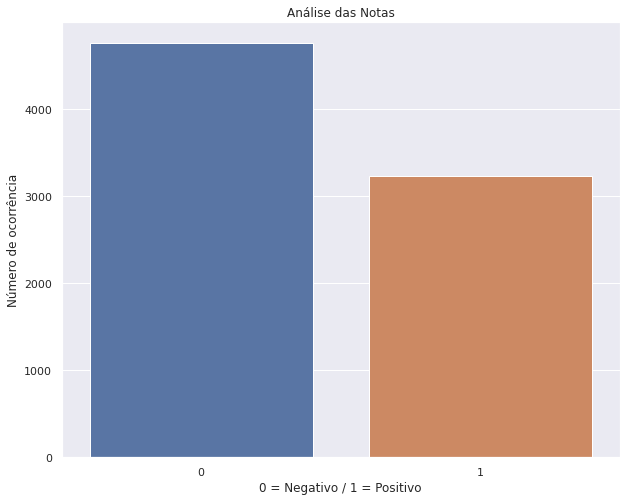

In [56]:
plt.figure(figsize=(10,8))
sns.countplot(x=Review_Nota['Nota'])
sns.set_theme(style='darkgrid')
plt.title('Análise das Notas')
plt.xlabel('0 = Negativo / 1 = Positivo')
plt.ylabel('Número de ocorrência')
plt.show()

Há mais reviews com notas negativas (1, 2 ou 3) do que positivas (4 e 5).

###Classes gramaticais

Podemos verificar quais as maiores ocorrências de classes gramaticais nas reviews.

In [58]:
nltk.download('averaged_perceptron_tagger')

classe = nltk.pos_tag(list_geral)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('i', 'NNS'),
 ('have', 'VBP'),
 ('get', 'VBN'),
 ('play', 'JJ'),
 ('console', 'NN'),
 ('honestly', 'RB'),
 ('say', 'VBP'),
 ('look', 'VBP'),
 ('x', 'JJ'),
 ('better', 'RBR')]

In [61]:
b = [] # lista que conterá as classes gramaticais
def classes(a, b): # função que fornecerá um dicionário
  for c in range(len(a)):
    b.append(a[c][1]) # adiciona o segundo elemento da lista 'classe'.

classes(classe, b)

num_clas = Counter(b) # numero de ocorrência das classes gramaticais

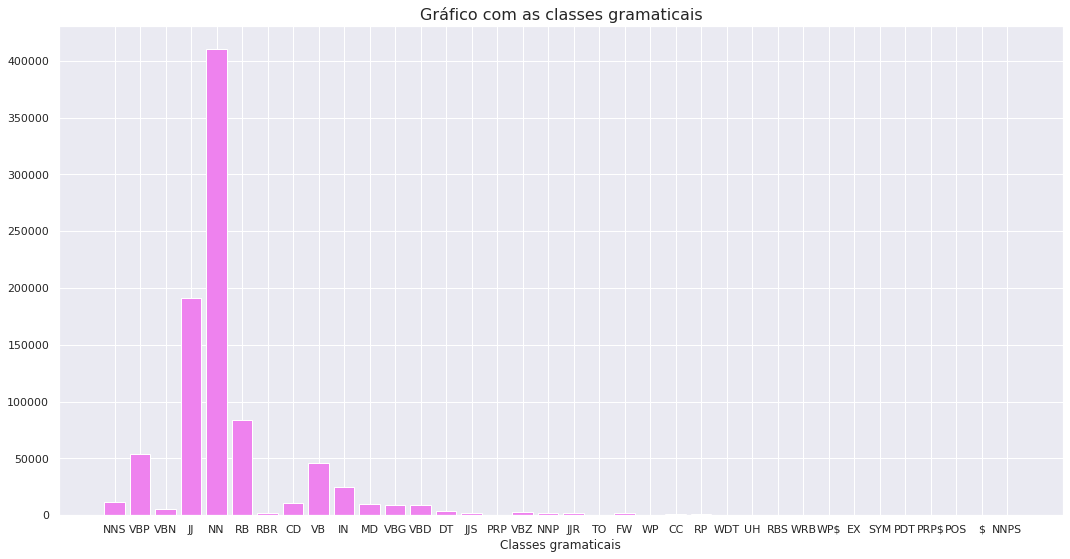

In [67]:
plt.figure(figsize = (18,9)) 
plt.bar(num_clas.keys(), num_clas.values(), color = 'violet')
plt.title('Gráfico com as classes gramaticais', fontsize = 16)
plt.xlabel('Classes gramaticais')
plt.show()

In [73]:
num_clas.most_common(6)

[('NN', 410088),
 ('JJ', 191051),
 ('RB', 83673),
 ('VBP', 54322),
 ('VB', 46209),
 ('IN', 24480)]

No gráfico dá para ver as classes gramaticais presentes e sua distribuição, tendo algumas se destacado. Segue as 6 mais presentes nas reviews:

NN = Substantivo

JJ = Adjetivo ou numeral

RB = Advérbio

VBP = Verbo no tempo presente e sem ser na terceira pessoa do singular

VB = Verbo

IN = Preposição ou conjunção 

##Modelagem

Para trabalhar com as reviews, será necessário transformá-las em features e, para fazer isso, podemos usar dois métodos: **Bag of Words** (BoW) ou **TF-IDF**.

###Bag of Words

Aqui, a ordem das palavras não importa, mas sim o número de ocorrências dessas palavras, ou seja, seu contexto não é capturado.

In [95]:
# Primeiro, juntarei o dataset de teste e validação.

df_teste = pd.merge(df_test, df_dev, how = 'outer')

In [76]:
# Importando o CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer as CV

BOWvectorizer = CV(max_features = 3000)

In [96]:
BOWtrain = BOWvectorizer.fit_transform(df_train['Review'])
BOWtest = BOWvectorizer.transform(df_teste['Review'])

In [106]:
print(BOWtrain)

  (0, 1192)	1
  (0, 1102)	1
  (0, 1914)	1
  (0, 527)	1
  (0, 1238)	1
  (0, 2245)	1
  (0, 1512)	1
  (0, 252)	1
  (0, 2013)	2
  (0, 1585)	1
  (0, 2979)	1
  (0, 1794)	1
  (0, 1610)	1
  (0, 1400)	1
  (1, 1914)	1
  (1, 1073)	3
  (1, 1111)	1
  (1, 2305)	1
  (1, 2954)	1
  (1, 2029)	1
  (1, 973)	1
  (1, 351)	1
  (1, 937)	1
  (1, 497)	1
  (1, 982)	1
  :	:
  (7998, 75)	1
  (7998, 2479)	1
  (7998, 970)	1
  (7998, 1435)	2
  (7998, 1906)	1
  (7998, 787)	2
  (7998, 2448)	1
  (7998, 1258)	1
  (7998, 2951)	1
  (7998, 226)	2
  (7998, 1762)	1
  (7998, 2499)	1
  (7998, 113)	1
  (7998, 2141)	1
  (7998, 1404)	1
  (7998, 2056)	1
  (7998, 1623)	1
  (7998, 508)	2
  (7998, 1186)	1
  (7998, 2839)	1
  (7998, 2424)	1
  (7998, 1357)	1
  (7998, 565)	3
  (7998, 1201)	2
  (7998, 1780)	1


###TF-IDF

TF-IDF é uma medida estatística, que ponderaa a importância de cada palavra dado o quanto ela aparece num documento em específico em relação ao corpus (conjunto de documentos) como um todo.

In [102]:
TFIDFvec = TfidfVectorizer(max_features = 3000)

In [103]:
TFIDFtrain = TFIDFvec.fit_transform(df_train['Review'])
TFIDFtest = TFIDFvec.transform(df_teste['Review'])

In [104]:
print(TFIDFtrain)

  (0, 1400)	0.23918609004062996
  (0, 1610)	0.3421074805338718
  (0, 1794)	0.13253570269633583
  (0, 2979)	0.25344322363590205
  (0, 1585)	0.259505995778478
  (0, 2013)	0.44983851567132516
  (0, 252)	0.23345741086946054
  (0, 1512)	0.16985128061206087
  (0, 2245)	0.17358922702263532
  (0, 1238)	0.32790111129119415
  (0, 527)	0.2716685793055046
  (0, 1914)	0.11475184577573805
  (0, 1102)	0.11740754875282754
  (0, 1192)	0.39050574853209197
  (1, 1061)	0.1332512462900681
  (1, 478)	0.1568860093811589
  (1, 289)	0.37950215282849353
  (1, 1640)	0.2370375421830785
  (1, 2370)	0.23377313103113614
  (1, 1777)	0.3668928588913669
  (1, 982)	0.24877692039692317
  (1, 497)	0.35641219143225245
  (1, 937)	0.18478341716369612
  (1, 351)	0.14303565272296045
  (1, 973)	0.24693656992075563
  :	:
  (7998, 2664)	0.05458151568533076
  (7998, 2345)	0.07667877138611481
  (7998, 2413)	0.10659413593289567
  (7998, 1367)	0.3427030742916822
  (7998, 1562)	0.12286517664876308
  (7998, 765)	0.09273153049165125
  (

###Aplicação dos modelos

In [109]:
# Aqui separamos a target
notas_treino = df_train['Nota']
notas_teste = df_teste['Nota']

In [110]:
X_train_BOW = BOWtrain
X_train_TFIDF = TFIDFtrain
y_train = notas_treino

X_test_BOW = BOWtest
X_test_TFIDF = TFIDFtest
y_test = notas_teste

In [116]:
# Importando as métricas a serem usadas
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

####Logistic Regression

In [112]:
from sklearn.linear_model import LogisticRegression

In [121]:
model = LogisticRegression()
model.fit(X_train_TFIDF, y_train)

# Função para a análise das métricas
def mostra_metricas(y_true, y_pred):
  ConfusionMatrixDisplay.from_estimator(model, X_test_TFIDF, y_test)
  print("\nAcurácia: ", accuracy_score(y_true, y_pred))
  print("\n",classification_report(y_true, y_pred))
  print("Matriz de confusão:")

#####Bag of Words

In [113]:
# Instanciando a regressão logistica
reglog = LogisticRegression()

# Aplicando o modelo
reglog.fit(X_train_BOW, y_train)

# Predicao
y1_reglog_pred = reglog.predict(X_test_BOW)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



Acurácia:  0.7657257168259614

               precision    recall  f1-score   support

           0       0.81      0.80      0.81      2738
           1       0.70      0.71      0.70      1761

    accuracy                           0.77      4499
   macro avg       0.75      0.76      0.76      4499
weighted avg       0.77      0.77      0.77      4499

Matriz de confusão:


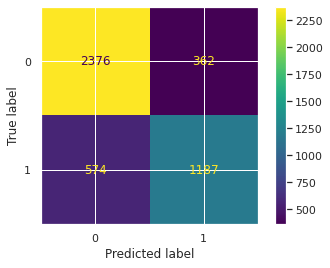

In [122]:
mostra_metricas(y_test , y1_reglog_pred)

#####TF-IDF

In [123]:
reglog2 = LogisticRegression()

reglog2.fit(X_train_TFIDF, y_train)

y2_reglog_pred = reglog2.predict(X_test_TFIDF)


Acurácia:  0.7919537675038898

               precision    recall  f1-score   support

           0       0.81      0.87      0.84      2738
           1       0.77      0.67      0.72      1761

    accuracy                           0.79      4499
   macro avg       0.79      0.77      0.78      4499
weighted avg       0.79      0.79      0.79      4499

Matriz de confusão:


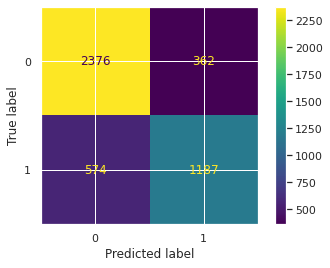

In [124]:
mostra_metricas(y_test, y2_reglog_pred)

####Naive Bayes

#####Bag of Words

In [125]:
from sklearn.naive_bayes import GaussianNB

In [131]:
gnb1 = GaussianNB()

gnb1.fit(X_train_BOW.toarray(), y_train)

y1_gnb_pred = gnb1.predict(X_test_BOW.toarray())


Acurácia:  0.6016892642809514

               precision    recall  f1-score   support

           0       0.78      0.48      0.59      2738
           1       0.49      0.80      0.61      1761

    accuracy                           0.60      4499
   macro avg       0.64      0.64      0.60      4499
weighted avg       0.67      0.60      0.60      4499

Matriz de confusão:


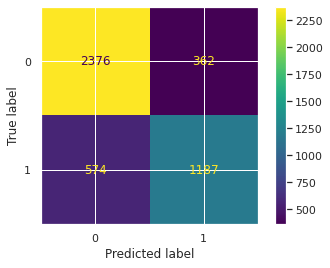

In [132]:
mostra_metricas(y_test, y1_gnb_pred)

#####TF-IDF

In [143]:
gnb2 = GaussianNB()

gnb2.fit(X_train_TFIDF.toarray(), y_train)

y2_gnb_pred = gnb2.predict(X_test_TFIDF.toarray())


Acurácia:  0.6810402311624806

               precision    recall  f1-score   support

           0       0.77      0.68      0.72      2738
           1       0.58      0.68      0.63      1761

    accuracy                           0.68      4499
   macro avg       0.67      0.68      0.67      4499
weighted avg       0.69      0.68      0.68      4499

Matriz de confusão:


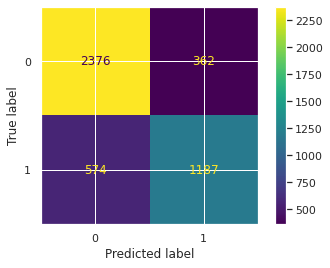

In [144]:
mostra_metricas(y_test, y2_gnb_pred)

####Árvore de decisão

#####Bag of Words

In [130]:
from sklearn.tree import DecisionTreeClassifier

In [151]:
model = DecisionTreeClassifier()

model.fit(X_train_BOW, y_train)

y_pred_bow = model.predict(X_test_BOW)


Acurácia:  0.6345854634363192

               precision    recall  f1-score   support

           0       0.71      0.68      0.70      2738
           1       0.53      0.56      0.54      1761

    accuracy                           0.63      4499
   macro avg       0.62      0.62      0.62      4499
weighted avg       0.64      0.63      0.64      4499

Matriz de confusão:


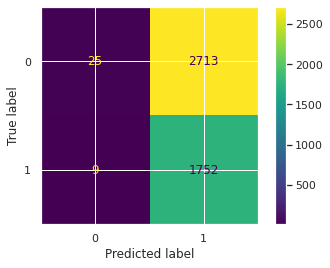

In [152]:
mostra_metricas(y_test, y_pred_bow)

#####TF-IDF

In [153]:
model = DecisionTreeClassifier()

model.fit(X_train_TFIDF, y_train)

y_pred_tfidf = model.predict(X_test_TFIDF)


Acurácia:  0.6414758835296732

               precision    recall  f1-score   support

           0       0.71      0.69      0.70      2738
           1       0.54      0.57      0.55      1761

    accuracy                           0.64      4499
   macro avg       0.63      0.63      0.63      4499
weighted avg       0.65      0.64      0.64      4499

Matriz de confusão:


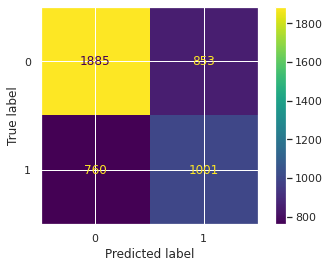

In [154]:
mostra_metricas(y_test, y_pred_tfidf)

####Conclusões

Conforme as métricas aqui apresentadas, a regressão logística apresentou os melhores resultados, especialmente com TF-IDF, com a acurácia de aproximadamente 79,1%. Com isso, utilizarei esse método para testar nas seguintes predições:

In [155]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [157]:
def nova_predicao(texto):
  texto_vetorizado = TFIDFvec.transform([texto])
  pred = reglog2.predict(texto_vetorizado)

  if pred == 0:
    print("Review negativa.")
  else:
    print("Review positiva.")

In [162]:
nova_predicao("A lot of bugs but overall very enjoyable experience")

Review positiva.


In [164]:
nova_predicao("This is an absolute garbage and robbery. The game is too bugged on all levels and is much worse in almost every terms comparing with DL1. DON'T buy this game until they will do some patches")

Review negativa.


Parece que funciona bem ihuuuuu

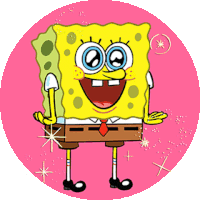

##Embeddings (Word2Vec)

to be continued...